In [90]:
import pandas as pd
import numpy as np
from equity_plot import equity_plot
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from datetime import datetime
from itertools import compress
from scipy import stats
# import qgrid
import yfinance as yf
import datetime as dt
import time
from progressbar import *
from ipywidgets import interact
import random
import pandas_market_calendars as mcal
import bisect 
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('ggplot')
# plt.rcParams['font.sans-serif'] = ['SimHei']
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 30

Data

In [91]:
stock_price = pd.read_csv(r"C:\Users\qwtl0\Python\TMBA_data\TEJ_調整後股價資料\收盤價(元).csv")
stock_lend1 = pd.read_csv(r"C:\Users\qwtl0\Python\TMBA_data\TEJ_融資融券\融資維持率.csv")
stock_lend2 = pd.read_csv(r"C:\Users\qwtl0\Python\TMBA_data\TEJ_融資融券\融券維持率.csv")
stock_market = pd.read_csv(r"C:\Users\qwtl0\Python\TMBA_data\TEJ_借券餘額\市場別.csv")
stock_volume = pd.read_csv(r"C:\Users\qwtl0\Python\TMBA_data\TEJ_調整後股價資料\成交值(千元).csv")
industry = pd.read_csv(r"C:\Users\qwtl0\Python\TMBA_data\industry.csv")

Time

In [92]:
bt_start = "2012-01-01"
bt_end = "2021-10-01"

Data Preprocessed

In [93]:
stock_df = stock_price.copy()
stock_df['年月日'] = pd.to_datetime(stock_df['年月日'].astype('str'))
stock_df = stock_df.set_index('年月日')
stock_df = stock_df.loc[bt_start:bt_end]

market_df = stock_market.copy()
market_df['年月日'] = pd.to_datetime(market_df['年月日'].astype('str'))
market_df = market_df.set_index('年月日')
market_df = market_df.loc[bt_start:bt_end]

volume_df = stock_volume.copy()
volume_df['年月日'] = pd.to_datetime(volume_df['年月日'].astype('str'))
volume_df = volume_df.set_index('年月日')
volume_df = volume_df.loc[bt_start:bt_end]

industry['公司簡稱'] = industry['公司簡稱'].astype(str)
industry_df = industry.copy()

In [94]:
def df_preprocess(factor_df,stock_df,market_df) : 
    
    df = factor_df.copy()
    df['年月日'] = pd.to_datetime(df['年月日'].astype('str'))
    df = df.set_index('年月日')
    df = df.loc[bt_start:bt_end].replace(['           -','      -','     -','              -','        -','            -'],np.nan).astype('float')

    stock_set = set(stock_df.columns) & set(df.columns)
    stock_df = stock_df[list(stock_set)]
    df = df[list(stock_set)]
    stock_close = stock_df.copy()
    
    return df , stock_close , len(stock_df.columns)

In [95]:
def backtest(df,long_cut,short_cut,cut_size) :
    try :
        ret_long_list = []
        ret_short_list = []
        tic_long_list = []
        tic_short_list = []
        ret_port_list = []
        
        
        sharpe_list = [[],[],[]]
        mdd_list = [[],[],[]]
        ret_mdd_list = [[],[],[]]
        annual_return_list = [[],[],[]]
        
        long_cut = long_cut
        short_cut = short_cut
        cut_size = cut_size
        cost = -0.001425

        data1 = df
        # data1 = lend_df
        # data2 = stock_df
        # data3 = stock_21day_high

        for i in range(1,len(rebalance_list['start'])) :

            #     訊號
            long_signal = stock_signal(rebalance_list['end'][i-1],cut_size,long_cut,data1)
            short_signal = stock_signal(rebalance_list['end'][i-1],cut_size,short_cut,data1)
            #     回測
            ret_long_factor = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],long_signal].pct_change().fillna(0).cumsum().iloc[-1,:].values 

            ret_short_factor = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],short_signal].pct_change().fillna(0).cumsum().iloc[-1,:].values 

            ret_long = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],long_signal].pct_change().fillna(0).T.mean()

            tic_long = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],long_signal].columns

            ret_short = (stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],short_signal].pct_change()*(-1)).fillna(0).T.mean()

            tic_short = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],short_signal].columns

            if long_signal.values.squeeze() != [] :
                ret_long[0] = cost
                ret_short[0] = cost

            ret_long_list.append(ret_long)
            tic_long_list.append(tic_long)

            ret_short_list.append(ret_short)
            tic_short_list.append(tic_short)

            ret_port_list.append((ret_long+ret_short)/2)

        ret_long_df = pd.DataFrame(pd.DataFrame(ret_long_list).fillna(0).sum())
        tic_long_df = pd.DataFrame(tic_long_list)
        ret_short_df = pd.DataFrame(pd.DataFrame(ret_short_list).fillna(0).sum())
        tic_short_df = pd.DataFrame(tic_short_list)
        ret_port_df = (ret_long_df+ret_short_df)/2
        
        z = 0
        for strategy_df in [ret_long_df,ret_short_df,ret_port_df] :
            sharpe = round(strategy_df.mean()/strategy_df.std()*(252**(1/2)),2)
            mdd = (strategy_df.cumsum().cummax()-strategy_df.cumsum()).max()
            ret_mdd =round((strategy_df.cumsum().iloc[-1])/mdd,2)
            total_days = (strategy_df.cumsum().index[-1] - strategy_df.cumsum().index[0]).days
            annualized_return = (strategy_df.cumsum().iloc[-1])/(total_days/365)
            
            sharpe_list[z].append(sharpe)
            mdd_list[z].append(mdd)
            ret_mdd_list[z].append(ret_mdd)
            annual_return_list[z].append(annualized_return)
            z += 1
            
        return ret_long_df, ret_short_df, ret_port_df,sharpe_list,ret_mdd_list,mdd_list,annual_return_list
    
    except ValueError:
        next

Condition

In [97]:
def stock_signal(rebalance_day,cut_size,cut,data) :
    unlist_stock = market_df.loc[rebalance_day][market_df.loc[rebalance_day] == 'TSE  '].index
    df = pd.qcut(data.loc[rebalance_day,unlist_stock].dropna().rank(method = 'first'),
                 q = cut_size,labels = [x for x in range(1,cut_size+1)],duplicates = 'drop') == cut
    signal = df.keys()[df]
    return signal

Rebalance Day

In [96]:
start_list = []
rebalance_day = 14
for x in range(len(stock_df.index)) :
    if x%rebalance_day == 0:
        start_list.append(stock_df.index[x])
        
end_list = []
for x in range(len(stock_df.index)-(rebalance_day-1)) :
    if x%rebalance_day == 0:
        end_list.append(stock_df.index[x+(rebalance_day-1)])

In [98]:
rebalance_list = {'start' : start_list[:len(end_list)],'end' : end_list}
pd.DataFrame(rebalance_list)

,start,end
0,2012-01-02,2012-01-30
1,2012-01-31,2012-02-16
2,2012-02-17,2012-03-08
3,2012-03-09,2012-03-28
4,2012-03-29,2012-04-18
...,...,...
165,2021-06-04,2021-06-24
166,2021-06-25,2021-07-14
167,2021-07-15,2021-08-03
168,2021-08-04,2021-08-23


Backtest

In [10]:
import os
filename = os.listdir(r'C:\Users\qwtl0\Python\TMBA_data\TEJ_融資融券')
path = r'C:\Users\qwtl0\Python\TMBA_data\TEJ_融資融券'

factor_return = {}
sharpe_dic = {}
ret_mdd_dic = {}
mdd_dic = {}
annual_return_dic = {}


start_time = time.time()

for factor in filename[1:] :
    factor_df = pd.read_csv(str(os.path.join(path,factor)))
    
    df , stock_close , stock_pool= df_preprocess(factor_df,stock_df,market_df)
    
    try :
        ret_long_df, ret_short_df, ret_port_df,sharpe_list,ret_mdd_list,mdd_list,annual_return_list = backtest(df,1,5,5)

        factor_return[factor[:-4]] = [ret_long_df.cumsum().values.squeeze()[-1],
                                     ret_short_df.cumsum().values.squeeze()[-1],
                                     ret_port_df.cumsum().values.squeeze()[-1]]
        
        sharpe_dic[factor[:-4]] = [sharpe_list[0][0].squeeze(),
                                  sharpe_list[1][0].squeeze(),
                                  sharpe_list[2][0].squeeze()]
        
        ret_mdd_dic[factor[:-4]] = [ret_mdd_list[0][0].squeeze(),
                                  ret_mdd_list[1][0].squeeze(),
                                  ret_mdd_list[2][0].squeeze()]
        
        mdd_dic[factor[:-4]] = [mdd_list[0][0].squeeze(),
                                  mdd_list[1][0].squeeze(),
                                  mdd_list[2][0].squeeze()]

        annual_return_dic[factor[:-4]] = [annual_return_list[0][0].squeeze(),
                                  annual_return_list[1][0].squeeze(),
                                  annual_return_list[2][0].squeeze()]
        
        print(factor[:-4],"提取成功")
    except TypeError :
        print(factor[:-4],"提取失敗")
end_time = time.time()
print('此次回測總共耗時 %f 秒' %(round(end_time-start_time,2)))

借券賣出(千元) 提取成功 : 
借券賣出(千元)_交易所 提取失敗
借券賣出(張) 提取成功 : 
借券賣出可使用額度 提取成功 : 
借券賣出庫存異動(千元) 提取成功 : 
借券賣出庫存異動(張) 提取成功 : 
借券賣出限額 提取成功 : 
借券賣出餘額(千元) 提取成功 : 
借券賣出餘額(張) 提取成功 : 
券資比 提取成功 : 
整戶維持率 提取成功 : 
每股融券成本 提取成功 : 
每股融資成本 提取成功 : 
融券(買+賣)除以成交量 % 提取成功 : 
融券使用率 提取成功 : 
融券增減(千元) 提取成功 : 
融券增減(張) 提取成功 : 
融券增減比率 提取成功 : 
融券現券償還(千元) 提取成功 : 
融券現券償還(張) 提取成功 : 
融券維持率 提取成功 : 
融券買進(千元) 提取成功 : 
融券買進(張) 提取成功 : 
融券賣出(千元) 提取成功 : 
融券賣出(張) 提取成功 : 
融券限額 提取成功 : 
融券餘額(千元) 提取成功 : 
融券餘額(張) 提取成功 : 
融資(買+賣)除以成交量 % 提取成功 : 
融資使用率 提取成功 : 
融資增減(千元) 提取成功 : 
融資增減(張) 提取成功 : 
融資增減比率 提取成功 : 
融資現金償還(千元) 提取成功 : 
融資現金償還(張) 提取成功 : 
融資維持率 提取成功 : 
融資買進(千元) 提取成功 : 
融資買進(張) 提取成功 : 
融資賣出(千元) 提取成功 : 
融資賣出(張) 提取成功 : 
融資限額 提取成功 : 
融資餘額(千元) 提取成功 : 
融資餘額(張) 提取成功 : 
資券互抵 提取成功 : 
此次回測總共耗時 299.980000 秒


In [11]:
score_list = []
for i in [factor_return, annual_return_dic,sharpe_dic, mdd_dic,ret_mdd_dic] :
    score_df = pd.DataFrame(i, index = ['Long','Short','Port']).T.sort_values('Long',ascending = False).head(15)
    score_list.append(score_df)

<AxesSubplot:>

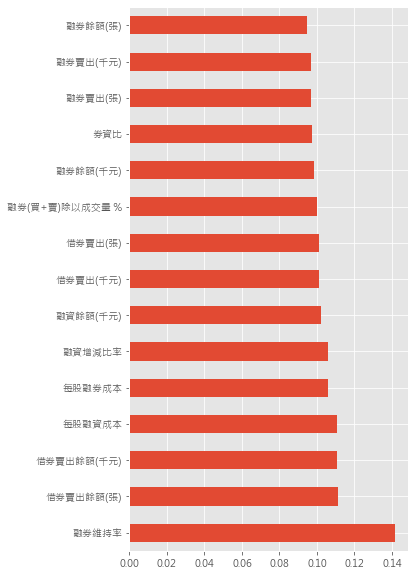

In [16]:
score_list[1].Long.plot(kind = 'barh',figsize = (5,10))

In [115]:
def backtest_ic_ir(df) :
    try :
        ret_long_list = []  
        ic_long_list = []
        ic_pvalue_list = []
        ir_list = []
        date_list = []
        data1 = df
        # data1 = lend_df
        # data2 = stock_df
        # data3 = stock_21day_high

        for i in range(1,len(rebalance_list['start'])) :

            #     訊號
            long_signal = stock_signal(rebalance_list['end'][i-1],1,1,data1)

            #     回測
            ret_long_factor_values = df.loc[rebalance_list['end'][i-1],long_signal].values
            ret_long_factor_values = pd.Series(ret_long_factor_values).rank(ascending = False)
            
            ret_long = stock_close.loc[rebalance_list['start'][i]:rebalance_list['end'][i],long_signal].pct_change().fillna(0).cumsum().tail(1).melt().value
            ret_long = pd.Series(ret_long).rank(ascending = False)
            
            ic = stats.spearmanr(ret_long_factor_values,ret_long.values)[0]
            ic_pvalue = stats.spearmanr(ret_long_factor_values,ret_long.values)[1]
            
            ic_long_list.append(ic)
            ic_pvalue_list.append(ic_pvalue)
            
            date_list.append(rebalance_list['end'][i-1])

        ic_df = pd.DataFrame([ic_long_list,ic_pvalue_list],index = ['Rank_IC','P-value']).T
        ic_df['Rank_IR'] = ic_df['Rank_IC'].mean()/ic_df['Rank_IC'].std()
        ic_df_raw = ic_df
        ic_df = ic_df.mean()
        
        return ic_df, ic_df_raw , date_list
    
    except ValueError:
        
        print("因子分組失敗")
        next

In [43]:
import os
filename = os.listdir(r'C:\Users\qwtl0\Python\TMBA_data\TEJ_融資融券')
path = r'C:\Users\qwtl0\Python\TMBA_data\TEJ_融資融券'

IC_dic = {}


start_time = time.time()

for factor in filename[1:] :
    factor_df = pd.read_csv(str(os.path.join(path,factor)))
    
    df , stock_close , stock_pool= df_preprocess(factor_df,stock_df,market_df)
    
    if stock_pool != 0 :
        ic_df,ic_data_ret = backtest_ic_ir(df)
        IC_dic[factor[:-4]] = ic_df
        
        print(factor[:-4],"提取成功")
    else :
        print(factor[:-4],"提取失敗")
end_time = time.time()
print('此次回測總共耗時 %f 秒' %(round(end_time-start_time,2)))

借券賣出(千元) 提取成功


KeyboardInterrupt: 

In [138]:
import os

IC_dic = {}

start_time = time.time()
    
df , stock_close , stock_pool= df_preprocess(stock_lend1,stock_df,market_df)

if stock_pool != 0 :
    ic_df,ic_df_raw,date_list = backtest_ic_ir(df)
    IC_dic[factor[:-4]] = ic_df

    print(factor[:-4],"提取成功")
else :
    print(factor[:-4],"提取失敗")
end_time = time.time()
print('此次回測總共耗時 %f 秒' %(round(end_time-start_time,2)))

借券賣出(千元)_交易所 提取成功
此次回測總共耗時 2.880000 秒


<AxesSubplot:title={'center':'融資維持率 Rank IC'}>

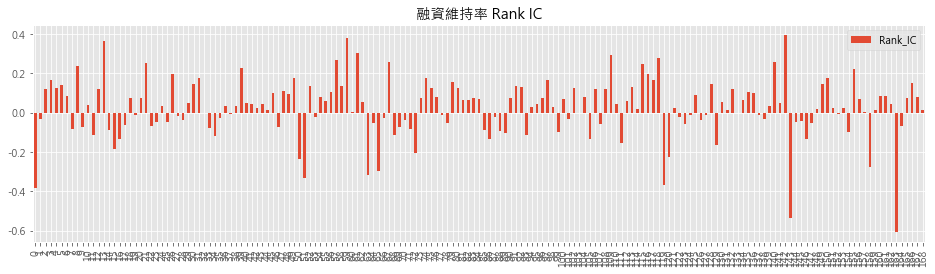

In [140]:
ic_df_raw[['Rank_IC']].plot(kind = 'bar',figsize = (16,4),title = '融資維持率 Rank IC')

array([<AxesSubplot:title={'center':'Rank_IR'}>], dtype=object)

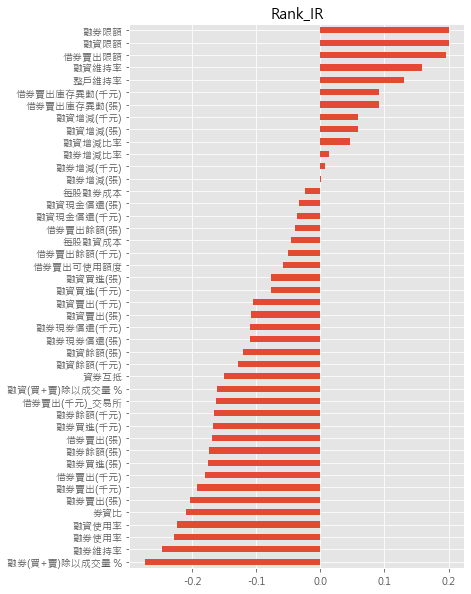

In [20]:
pd.DataFrame(IC_dic).T.sort_values(['Rank_IR'],ascending = True)['Rank_IR'].plot(kind = 'barh',figsize = (6,10),subplots = True)